In this workshop we will work on a project to construct a simulation of a gas in a 2d box. You may have seen something similar on your lectures though here our simulation will be a bit simpler.

We will be simulating an ideal gas so particles will collide with each other and the walls of the box in a perfectly elastic manner. The aim will be given to simulate N particles, in a box of size L x L, give some initial conditions, namely the positions and momementa of the particles involved.

We would also like to calculate some properties of the gas, e.g. total energy, centre of mass, temperature, etc.

To get an idea of how to construct our classes lets try and apply the reasoning mentioned at the end of the last lecture


In [61]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell
from IPython.core.display import clear_output, display

import matplotlib.animation as animation

%matplotlib nbagg

In [168]:
class Particle(object):
    def __init__(self, position, momentum, radius=2, mass=1):
        self.position = position
        self.momentum = momentum
        self.radius = radius
        self.mass = mass
    
    def kinetic_energy(self):
        return 0.5*np.sum(self.momentum**2)/self.mass
    
    def velocity(self):
        return self.momentum/self.mass

    def speed(self):
        return np.sum(self.velocity()**2)**0.5
    
    def overlap(self, other):
        if np.linalg.norm(self.position - other.position) < self.radius + other.radius:
            return True
    
    #TODO?
    def pair_potential_energy(self,other):
        return 1
    
class Simulation(object):
    def __init__(self, no_particles=100, box_length=100, no_steps=100, dt=0.001, particles=None):
        self.box_length = box_length
        self.no_steps = no_steps
        self.no_particles = no_particles
        self.dt=dt
        
        self.traj_positions = None
        self.traj_momenta = None
        
        #useful for testing
        if particles:
            self.particles = particles
        else:
            self.particles = []
            for i in range(no_particles):
                position_vector = np.random.random(2)*self.box_length
                momentum_vector = (np.random.random(2)-0.5) * self.box_length*3
                self.particles.append(Particle(position_vector, momentum_vector))
        
    def update_positions(self):
        for particle in self.particles:
            particle.position += (particle.momentum/particle.mass)*self.dt

    def update_momenta(self):
        for i,particle in enumerate(self.particles):
            self.apply_box_collisions(particle)
            self.apply_particle_collisions(particle, i)

    def apply_box_collisions(self, particle):
        if (particle.position[1] <0 and particle.momentum[1] <0) or (particle.position[1] > self.box_length and particle.momentum[1] >0):
            particle.momentum[1] *= -1
       
        if (particle.position[0] <0 and particle.momentum[0] <0) or (particle.position[0] > self.box_length and particle.momentum[0] >0):
            particle.momentum[0] *= -1
            
    def apply_particle_collisions(self, particle, i):
        for j,other_particle in enumerate(self.particles):
            if j > i and particle.overlap(other_particle):    
                delta_position = other_particle.position - particle.position
                collision_axis = delta_position / np.linalg.norm(delta_position)

                particle_axis_momentum = collision_axis * particle.momentum.dot(collision_axis)
                other_particle_axis_momentum = collision_axis * other_particle.momentum.dot(collision_axis)
                
                #are they moving towards each other?
                delta_momentum = other_particle.momentum - particle.momentum
                if delta_momentum.dot(collision_axis) <= 0:
                    particle.momentum = particle.momentum - particle_axis_momentum + other_particle_axis_momentum
                    other_particle.momentum = other_particle.momentum - other_particle_axis_momentum + particle_axis_momentum
    
    def clunky_display_frame(self, fig,ax):
        particle_x = [p.position[0] for p in self.particles]
        particle_y = [p.position[1] for p in self.particles]

        ax.cla() # clear current axis
        plt.plot(particle_x, particle_y, c='b',linestyle='', marker='o',markersize=16.5) #plot all particles and set the marker size to be large
        ax.set_xlim(-2, self.box_length+2) # set x and y limits with a bit of extra padding
        ax.set_ylim(-2, self.box_length+2)
        
        display(fig)
        #time.sleep(0.1)
        clear_output(wait=True)
     
    def animate_trajectory(self):
        def update_frame(i, positions, frame):
            frame.set_data(positions[..., i])
            return frame,
        
        fig = plt.figure(figsize=(10,10))
        frame, = plt.plot([],[],  c='b',linestyle='', marker='o',markersize=16.5) # initialise plot
        
        plt.xlim(-2, self.box_length+2) # set x and y limits with a bit of extra padding
        plt.ylim(-2, self.box_length+2)
        
        frame_ani = animation.FuncAnimation(fig, update_frame, self.no_steps, fargs=(self.traj_positions,frame),
                                           interval=10, blit=True, repeat=False)

        return frame_ani
    
    def simulate(self):
        #initial position/momenta
        positions = [[p.position.copy() for p in self.particles]]
        momenta = [[p.momentum.copy() for p in self.particles]]
        
        #fig, ax = plt.subplots(figsize=(10,10))
        for step in range(self.no_steps):
            self.update_positions()
            self.update_momenta()
            #self.clunky_display_frame(fig,ax)
            positions.append([p.position.copy() for p in self.particles])
            momenta.append([p.momentum.copy() for p in self.particles])

        self.traj_positions = np.array(positions).T
        self.traj_momenta = np.array(momenta).T
    
    def display_final_speeds(self, bins=10):
        plt.figure()
        speeds = [p.speed() for p in self.particles]
        plt.hist(speeds, bins=bins)
        plt.show()
    
    #Need R in our own units
    def temperature(self):
        pass
        #pV/nR
    
    #Need to keep track of each collision and append the changed in momenta
    def pressure(self):
        pass

In [171]:
p1 = Particle(position = np.array([20.,20.]), momentum=np.array([0.,1.]))
p2 = Particle(position = np.array([20.,25.]), momentum=np.array([0.,0.]))

p3 = Particle(position = np.array([50.,20.]), momentum=np.array([1.,1.]))
p4 = Particle(position = np.array([55.,25.]), momentum=np.array([0.,0.]))

p5 = Particle(position = np.array([20.,55.]), momentum=np.array([0.,0.]))
p6 = Particle(position = np.array([25.,50.]), momentum=np.array([-1,1.]))

p7 = Particle(position = np.array([50.,50.]), momentum=np.array([1.,0.]))
p8 = Particle(position = np.array([55.,50.]), momentum=np.array([0.,0.]))

test_case = [p1,p2,p3,p4,p5,p6,p7,p8]

#s=Simulation(no_particles=8,particles = test_case)
s=Simulation(no_particles=200, no_steps=100)
s.simulate()

<IPython.core.display.Javascript object>


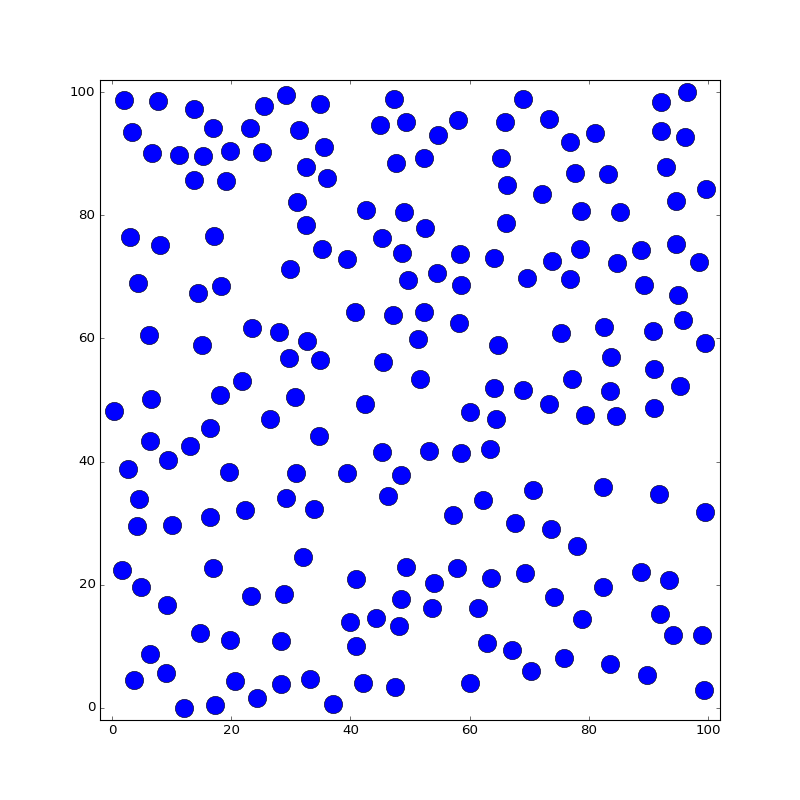

In [172]:
s.animate_trajectory()

<IPython.core.display.Javascript object>


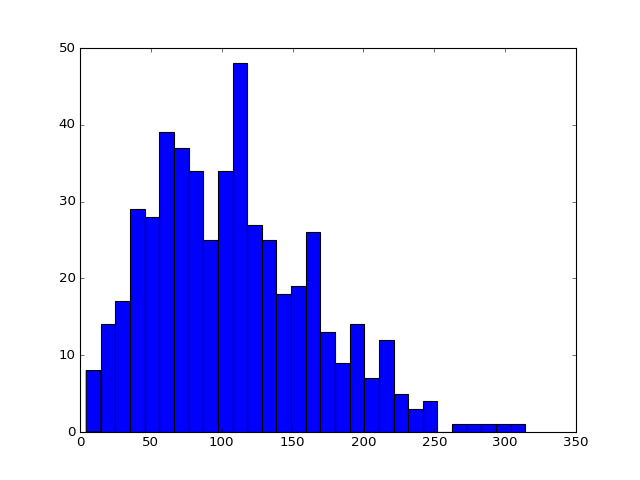

In [158]:
s.display_final_speeds(30)

<IPython.core.display.Javascript object>


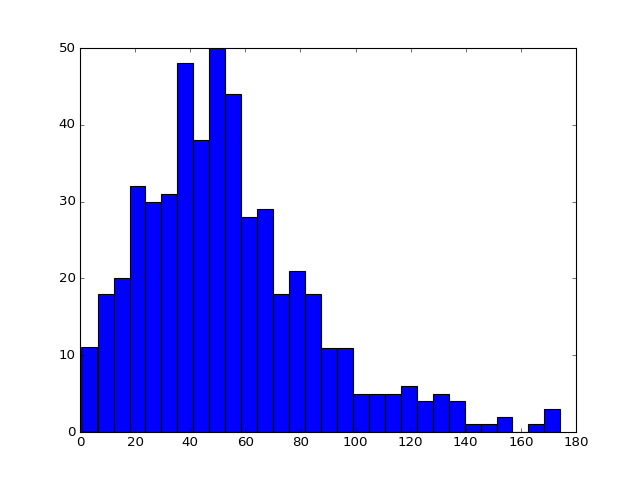

In [147]:
s.display_final_speeds(30)

<IPython.core.display.Javascript object>


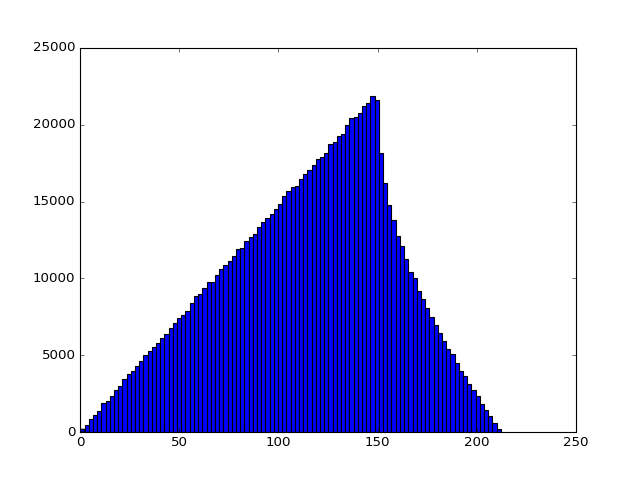

In [153]:
#what distribution do we start with?

test_vs = [(np.random.random(2)-0.5) * 100*3 for _ in range(1000000)]
test_s = [np.linalg.norm(v) for v in test_vs]

plt.figure()
plt.hist(test_s,bins=100)
plt.show()

<IPython.core.display.Javascript object>


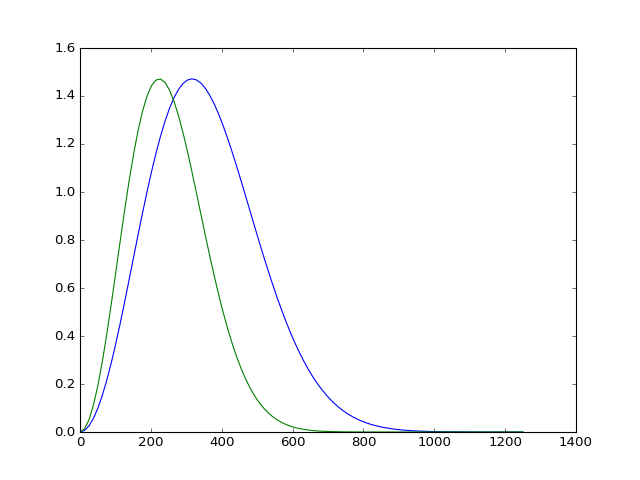

In [144]:
from scipy.stats import maxwell

plt.figure()
x = np.linspace(0,1250,100)
#scale = sqrt(kT/m)
#k/m for neon ~500 
#@~300k scale ~= 387
# 2500 ms^-1 ~= 350 x
# 1x = 7.5 ms^-1
# radius = 15m!
# neon radius 

##2d maxwell scale = m/2kt
# neon = 1e-5
maxwell_2d = lambda v,a: 4*np.pi*v**2*(a/np.pi)*np.e**(-a*v**2)
#plt.plot(x,maxwell.pdf(x,scale=387))
plt.plot(x,maxwell_2d(x,1e-5))
plt.plot(x,maxwell_2d(x,2e-5))

plt.show()

##doubling mass -> peak shrinks by 33%
##same seen in simulation! :)

In [ ]:
plt.plot(*zip(*s.positions[10]),marker='o', linestyle='', markersize=15)
plt.show()

In [ ]:
np.array(zip(*s.positions[0])) - np.array(s.positions[0]).T

In [ ]:


class Test(object):   
    def __init__(self):
        pass
    
    def anim(self):
        def update_line(num, data, line):
            line.set_data(data[..., :num])
            return line,
        
        fig = plt.figure()

        data = np.random.rand(2, 25)
        l, = plt.plot([], [], linestyle='', marker='o')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel('x')
        plt.title('test')
        line_ani = animation.FuncAnimation(fig, update_line, 25, fargs=(data, l),
                                           interval=50, blit=True)
        return line_ani
    
    def other(self):
        return self.anim()

In [ ]:
# Test()
# a.other()